# Cohort Case Study 1

In [103]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from raimitigations.utils import split_data, fetch_cohort_results
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager

SEED = 51

def _create_country_df(samples: int, sectors: dict, country_name: str):
    df = None
    for key in sectors.keys():
        size = int(samples * sectors[key]["prob_occur"])
        invest = np.random.uniform(low=sectors[key]["min"], high=sectors[key]["max"], size=size)
        min_invest = min(invest)
        max_invest = max(invest)
        range_invest = max_invest - min_invest
        bankrupt_th = sectors[key]["prob_success"] * range_invest
        bankrupt = []
        for i in range(invest.shape[0]):
            if invest[i] > bankrupt_th:
                bankrupt.append(0)
            else:
                bankrupt.append(1)
        noise_ind = np.random.choice(range(size), int(size*0.1), replace=False)
        for ind in noise_ind:
            bankrupt[ind] = int(not bankrupt[ind])
        noise_ind = np.random.choice(range(size), int(size*0.1), replace=False)
        for ind in noise_ind:
            invest[ind] = np.nan
        
        country_col = [country_name for _ in range(size)]
        sector_col = [key for _ in range(size)]
        df_sector = pd.DataFrame({
            "investment":invest,
            "sector":sector_col,
            "country":country_col,
            "bankrupt":bankrupt
        })
        
        if df is None:
            df = df_sector
        else:
            df = pd.concat([df, df_sector], axis=0)
    return df

In [104]:
def create_df_multiple_distributions(samples: list):
    np.random.seed(SEED)
    random.seed(SEED)
    sectors_c1 = {
        "s1": {"prob_occur":0.2, "prob_success":0.8, "min":20000, "max":100000},
        "s2": {"prob_occur":0.4, "prob_success":0.6, "min":1000, "max":15000},
        "s3": {"prob_occur":0.1, "prob_success":0.9, "min":1000000, "max":10000000},
        "s4": {"prob_occur":0.3, "prob_success":0.7, "min":4000000, "max":900000000},
    }
    sectors_c2 = {
        "s1": {"prob_occur":0.1, "prob_success":0.6, "min":1000, "max":5000},
        "s2": {"prob_occur":0.6, "prob_success":0.9, "min":100000, "max":1500000},
        "s3": {"prob_occur":0.2, "prob_success":0.5, "min":50000, "max":300000},
        "s4": {"prob_occur":0.1, "prob_success":0.8, "min":1000000, "max":10000000},
    }
    sectors_c3 = {
        "s1": {"prob_occur":0.3, "prob_success":0.9, "min":300, "max":600},
        "s2": {"prob_occur":0.6, "prob_success":0.7, "min":5000, "max":9000},
        "s3": {"prob_occur":0.07, "prob_success":0.8, "min":4000, "max":20000},
        "s4": {"prob_occur":0.03, "prob_success":0.5, "min":600000, "max":1300000},
    }
    countries = {
        "A":{"sectors":sectors_c1, "sample_rate":0.75},
        "B":{"sectors":sectors_c2, "sample_rate":0.1},
        "C":{"sectors":sectors_c2, "sample_rate":0.15}
    }
    df = None
    for key in countries.keys():
        n_sample = int(samples * countries[key]["sample_rate"])
        df_c = _create_country_df(n_sample, countries[key]["sectors"], key)
        if df is None:
            df = df_c
        else:
            df = pd.concat([df, df_c], axis=0)
    
    idx = pd.Index([i for i in range(df.shape[0])])
    df = df.set_index(idx)
    return df

In [105]:
df = create_df_multiple_distributions(8000)
df

,investment,sector,country,bankrupt
0,7.405851e+04,s1,A,0
1,2.357697e+04,s1,A,1
2,4.746429e+04,s1,A,1
3,NaN,s1,A,0
4,4.273704e+04,s1,A,0
...,...,...,...,...
7995,3.179612e+06,s4,C,1
7996,NaN,s4,C,1
7997,1.369849e+06,s4,C,1
7998,NaN,s4,C,1


In [106]:
subset = df.query("sector == 's1' and investment < 60000")
subset['bankrupt'].value_counts(normalize=True)

1    0.754076
0    0.245924
Name: bankrupt, dtype: float64

In [107]:
def get_model():
    #model = LGBMClassifier(random_state=SEED)
    model = LogisticRegression()
    return model

In [108]:
X_train, X_test, y_train, y_test = split_data(df, label="bankrupt", test_size=0.3)

pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(X_train, y_train)
pred_org = pipe.predict_proba(X_test)
    
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.663095,0.694157,0.694157,0.671667,0.671667
1,cohort_0,"(`country` == ""A"")",1822,0.671103,0.708470,0.692929,0.658388,0.660263
2,cohort_1,"(`country` == ""B"")",239,0.740440,0.765112,0.772763,0.760433,0.761506
3,cohort_2,"(`country` == ""C"")",339,0.754559,0.785382,0.796844,0.788938,0.796460


In [109]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
    ],
    cohort_col=["country"]
)

pipe = Pipeline([
            ("cht_preprocess", cht_manager),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(X_train, y_train)
pred_cht = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.670998,0.695311,0.695372,0.672917,0.672917
1,cohort_0,"(`country` == ""A"")",1822,0.682161,0.714008,0.701457,0.669442,0.670692
2,cohort_1,"(`country` == ""B"")",239,0.712734,0.726769,0.708117,0.671564,0.673640
3,cohort_2,"(`country` == ""C"")",339,0.754707,0.754630,0.758859,0.719676,0.719764


In [110]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["country"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.753558,0.762454,0.746831,0.751521,0.765833
1,cohort_0,"(`country` == ""A"")",1822,0.744274,0.767607,0.749365,0.754318,0.768386
2,cohort_1,"(`country` == ""B"")",239,0.804437,0.792141,0.800108,0.785876,0.786611
3,cohort_2,"(`country` == ""C"")",339,0.860982,0.813396,0.830842,0.815723,0.820059


In [111]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.816238,0.808020,0.807634,0.807824,0.814167
1,cohort_0,"(`country` == ""A"")",1822,0.823978,0.827257,0.829054,0.828095,0.832602
2,cohort_1,"(`country` == ""B"")",239,0.790909,0.787973,0.796284,0.788481,0.790795
3,cohort_2,"(`country` == ""C"")",339,0.862975,0.845299,0.857918,0.849763,0.855457


In [112]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.872189,0.852554,0.828777,0.836325,0.846250
1,cohort_0,"(`country` == ""A"")",1822,0.869854,0.862261,0.840291,0.847347,0.855653
2,cohort_1,"(`country` == ""B"")",239,0.863456,0.853427,0.853427,0.853427,0.857741
3,cohort_2,"(`country` == ""C"")",339,0.897158,0.842194,0.854042,0.846512,0.852507


## Checking the "sector" + "country" cohorts

In [113]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.663095,0.694157,0.694157,0.671667,0.671667
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",364,0.799769,0.842710,0.854417,0.844078,0.846154
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",33,0.690385,0.818182,0.796154,0.803571,0.818182
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.810526,0.894444,0.873684,0.882591,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",723,0.809994,0.855763,0.853529,0.851892,0.852006
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",128,0.746259,0.780976,0.805442,0.791667,0.843750
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",206,0.824654,0.778110,0.805250,0.790082,0.854369
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",194,0.813161,0.791302,0.827115,0.805913,0.850515
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",57,0.839177,0.834718,0.807165,0.819048,0.859649
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",68,0.625157,0.839655,0.747799,0.779459,0.867647


In [114]:
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.872189,0.852554,0.828777,0.836325,0.846250
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",364,0.880599,0.878674,0.863926,0.869593,0.876374
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",33,0.836538,0.818182,0.796154,0.803571,0.818182
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.852632,0.894444,0.873684,0.882591,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",723,0.886894,0.861878,0.855930,0.856615,0.857538
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",128,0.787415,0.887164,0.818027,0.845339,0.898438
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",206,0.886146,0.912895,0.828007,0.861444,0.917476
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",194,0.808461,0.855515,0.784078,0.811039,0.876289
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",57,0.845274,0.834718,0.807165,0.819048,0.859649
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",68,0.728302,0.839655,0.747799,0.779459,0.867647


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1) 
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

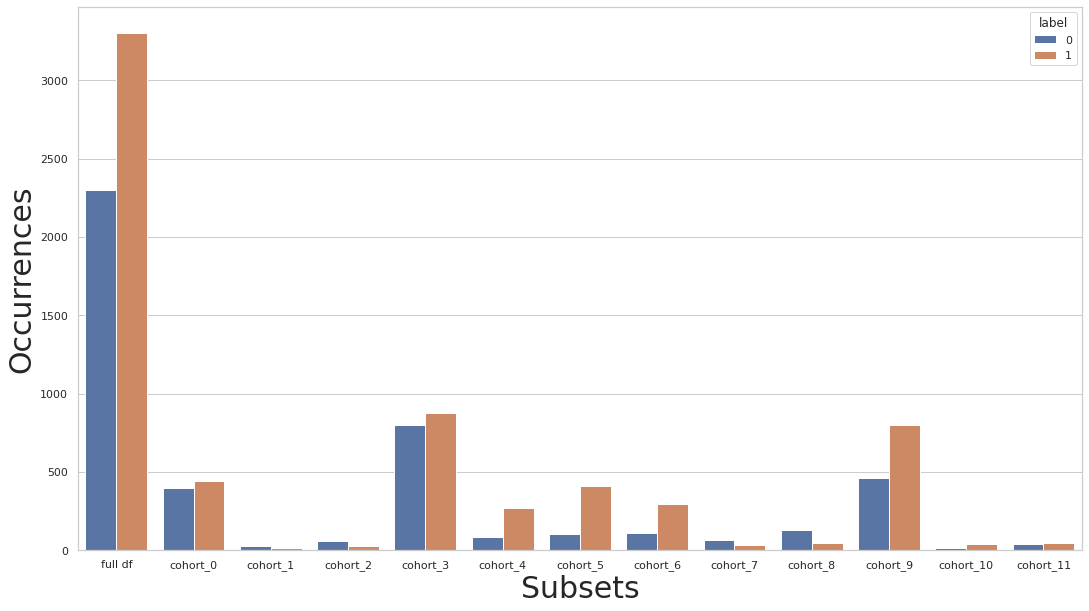

In [116]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

plot_value_counts_cohort(y_train, subsets, normalize=False)

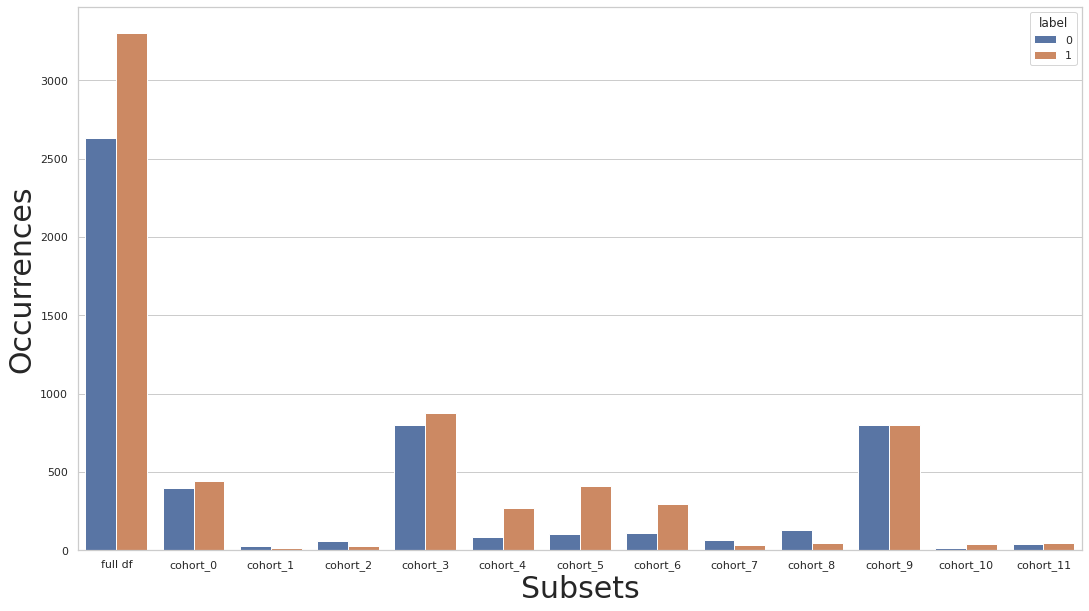

In [117]:

rebalance_cohort = CohortManager(
    transform_pipe=[[], [], [], [], [], [], [], [], [], dp.Rebalance(verbose=False), [], []],
    cohort_col=["sector", "country"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train,new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

In [118]:
pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)
    
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.647902,0.685703,0.683323,0.658248,0.658333
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",364,0.799769,0.842710,0.854417,0.844078,0.846154
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",33,0.690385,0.818182,0.796154,0.803571,0.818182
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.810526,0.894444,0.873684,0.882591,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",723,0.809994,0.855763,0.853529,0.851892,0.852006
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",128,0.746259,0.780976,0.805442,0.791667,0.843750
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",206,0.824654,0.778110,0.805250,0.790082,0.854369
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",194,0.813161,0.791302,0.827115,0.805913,0.850515
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",57,0.839177,0.834718,0.807165,0.819048,0.859649
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",68,0.625157,0.839655,0.747799,0.779459,0.867647


In [119]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,2400,0.871600,0.831829,0.820932,0.825124,0.833333
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",364,0.880599,0.878674,0.863926,0.869593,0.876374
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",33,0.836538,0.818182,0.796154,0.803571,0.818182
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.852632,0.894444,0.873684,0.882591,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",723,0.886894,0.861878,0.855930,0.856615,0.857538
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",128,0.787415,0.887164,0.818027,0.845339,0.898438
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",206,0.886146,0.912895,0.828007,0.861444,0.917476
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",194,0.808461,0.855515,0.784078,0.811039,0.876289
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",57,0.845274,0.834718,0.807165,0.819048,0.859649
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",68,0.728302,0.839655,0.747799,0.779459,0.867647
